In [3]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
model = 'gnoc' # 'gnoc', 'scn', 'escn'
enhancement = 'ca-gap' # 'vanilla', 'da', 'gap', 'da-gap'
train_status = 'ft' # 'pt', 'ft'
# mapping = {'vanilla': 'baseline',
#            'da': 'ca',
#            'gap': 'gap',
#            'da-gap': 'ca+gap'}
result_path = '/home/jovyan/shared-scratch/jhoon/ocp2023/results/attentions/indv/'
if train_status == 'pt':
    file_mapping = {'baseline': result_path+'attn-roberta-base-eval-gnoc-strc.pkl',
                    'gap': result_path+'attn-ssl-oc20-eqv2_1204_2048-eval-gnoc-strc.pkl',
                    'ca-gap': result_path+'attn-ssl-combined-eqv2_1207_1531-eval-gnoc-strc.pkl'}
elif train_status == 'ft':
    file_mapping = {'baseline': result_path+'attn-rebase3-vanilla-catberta_1223_1537-eval-gnoc-strc.pkl',
                    'ca': result_path+'attn-rebase3-da-catberta_1224_1518-eval-gnoc-strc.pkl',
                    'gap': result_path+'attn-rebase-gap-catberta_1221_2208-eval-gnoc-strc.pkl',
                    'ca-gap': result_path+'attn-rebase-da-gap-catberta_1226_0542-eval-gnoc-strc.pkl'}

In [7]:
# convert this to a dataframe where each column represents the section and each row represents the attention head
# the number of head is 12, the number of section is 4
attn = pd.read_pickle(file_mapping[enhancement])['weights']
df_attn = pd.DataFrame(attn).T

# Remove column named 3
df_attn.drop(columns=3, inplace=True)

# Change the remaining column names
df_attn.columns = ['Ads.', 'Cat.', 'Conf.']

# Calculate values for new '<s>' column
df_attn.insert(0, '<s>', 1 - (df_attn['Ads.'] + df_attn['Cat.'] + df_attn['Conf.']))

# add column-wise average row as 13th row
df_attn.loc['avg'] = df_attn.mean(axis=0)
df_attn

,<s>,Ads.,Cat.,Conf.
0,0.007417,0.246693,0.175139,0.570751
1,0.016497,0.186268,0.263079,0.534157
2,0.029387,0.279388,0.155295,0.535931
3,0.022711,0.107079,0.157644,0.712566
4,0.007382,0.196253,0.250250,0.546116
5,0.007907,0.075207,0.160977,0.755908
6,0.012264,0.410458,0.120468,0.456810
7,0.015098,0.383440,0.082125,0.519336
8,0.015516,0.098319,0.386257,0.499908
9,0.025863,0.250051,0.131465,0.592621


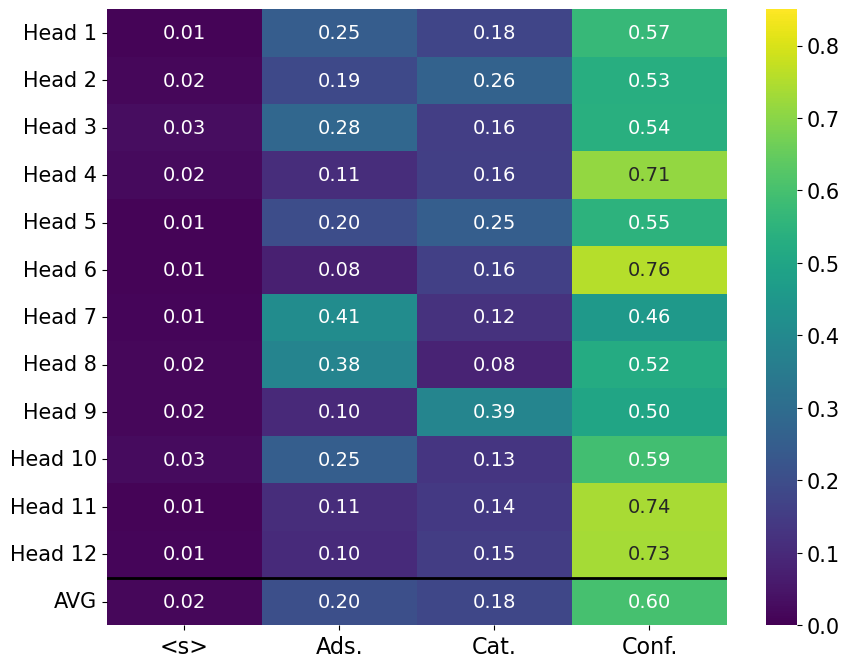

In [8]:
# Replace the ytick labels
ytick_labels = [f"Head {i+1}" for i in range(12)] + ["AVG"]

# Plotting heatmap
vmin = 0.0  # Set your minimum value
vmax = 0.85  # Set your maximum value
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_attn, annot=True, fmt=".2f", 
                      cmap='viridis', cbar=True, cbar_kws={'orientation': 'vertical'},
                      vmin=vmin, vmax=vmax)

# Enlarge the font of x, y ticks and ticks in the color bar
plt.xticks(fontsize=16)
plt.yticks(ticks=np.arange(len(df_attn)) + 0.5, labels=ytick_labels, rotation=0, fontsize=15)

# Adjust color bar tick label size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

# Place a line between Head 12 and AVG
plt.axhline(y=12, color='black', linewidth=2)

# Enlarge the text inside the plot (annotations)
for text in heatmap.texts:
    text.set_size(14)  # Adjust the font size as needed
# plt.savefig(f"attention/{model}_{mapping[enhancement]}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"attention/{train_status}_{model}_{enhancement}_rev.png", dpi=300, bbox_inches='tight')